# Evaluate the trained model

In [1]:
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [12]:
def load_doc(filename):
    file = open(filename)
    text = file.read()
    file.close()
    
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
            
        identifier = line.split('.')[0]
        dataset.append(identifier)
        
    return set(dataset)

def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
                
            desc = 'STARTSEQ ' + ' '.join(image_desc) + ' ENDSEQ'
            descriptions[image_id].append(desc)
    
    return descriptions

def load_photo_features(filename, dataset):
    all_features = pickle.load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    
    return features

def to_lines(descriptions):
    all_desc = list()
    
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer

def max_length(descriptions):
    lines = to_lines(descriptions)
    
    return max(len(d.split()) for d in lines)

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
        
    return None

# generate a description for a word
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'STARTSEQ'
    
    # iterate over the whole length of the sequence
    for _ in range(max_length):
        # integer-encode the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # predict next word
        y_hat = model.predict([photo, sequence], verbose=0)
        
        # convert proability to an integer
        y_hat = np.argmax(y_hat)
        
        # map integer to a word
        word = word_for_id(y_hat, tokenizer)
        
        # stop if the word cannot be mapped
        if word is None:
            break
            
        # append as input for generating the next word
        in_text += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'ENDSEQ':
            break
            
    return in_text

# remove start/end sequence tokens from a summary
def cleanup_summary(summary):
    # remove the start-of-sequence token
    index = summary.find('STARTSEQ ')
    
    if index > -1:
        summary = summary[len('STARTSEQ '):]
        
    # remove the end-of-sequence token
    index = summary.find(' ENDSEQ')
    
    if index > -1:
        summary = summary[:index]
        
    return summary

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        y_hat = generate_desc(model, tokenizer, photos[key], max_length)
        
        # cleanup prediction
        y_hat = cleanup_summary(y_hat)
        
        # store actual & predicted
        references = [cleanup_summary(d).split() for d in desc_list]
        actual.append(references)
        predicted.append(y_hat.split())
        
    # compute BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))    
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))    
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))    

In [13]:
''' EXECUTION CODE '''

# load training data
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('TRAINING DATASET: %d' % len(train))

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('DESCRIPTIONS: train=%d' % len(train_descriptions))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('VOCAB SIZE: %d' % vocab_size)

# maximum sequence length
max_length = max_length(train_descriptions)
print('DESCRIPTION LENGTH: %d' % max_length)


# load testing data
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('TESTING DATASET: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('DESCRIPTIONS: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features('features.pkl', test)
print('PHOTOS: test=%d' % len(test_features))

# load the model
filename = 'captioner_model_from_cloud.h5'
model = load_model(filename)

# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

TRAINING DATASET: 6000
DESCRIPTIONS: train=6000
VOCAB SIZE: 7579
DESCRIPTION LENGTH: 34
TESTING DATASET: 1000
DESCRIPTIONS: test=1000
PHOTOS: test=1000
BLEU-1: 0.118588
BLEU-2: 0.061192
BLEU-3: 0.044507
BLEU-4: 0.015130


## Generate new captions

In [2]:
import pickle
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model

In [3]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
            
        identifier = line.split('.')[0]
        dataset.append(identifier)

    return set(dataset)

def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
                
            desc = 'STARTSEQ ' + ' '.join(image_desc) + ' ENDSEQ'
            descriptions[image_id].append(desc)
    
    return descriptions

def to_lines(descriptions):
    all_desc = list()
    
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer


''' EXECUTION CODE '''
# training set
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('DATASET: %d' % len(train))

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('DESCRIPTIONS: train=%d' % len(train_descriptions))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

DATASET: 6000
DESCRIPTIONS: train=6000


In [4]:
def extract_features(filename):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    feature = model.predict(image, verbose=0)
    
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
        
    return None

def cleanup_summary(summary):
    index = summary.find('STARTSEQ ')
    if index > -1:
        summary = summary[len('STARTSEQ '):]
        
    index = summary.find(' ENDSEQ')
    if index > -1:
        summary = summary[:index]
        
    # this was added as a gotcha for a quirk with repeated 'endseq' statements    
    index = summary.find('endseq')
    if index > -1:
        summary = summary[:index]
        
    return summary

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'STARTSEQ'
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        y_hat = model.predict([photo, sequence], verbose=0)
        y_hat = np.argmax(y_hat)
        
        word = word_for_id(y_hat, tokenizer)
        
        if word is None:
            break
            
        in_text += ' ' + word
        if word == 'ENDSEQ':
            break
            
    return in_text

AI-generated caption:
*********************
 football player in red and white uniform is playing soccer 


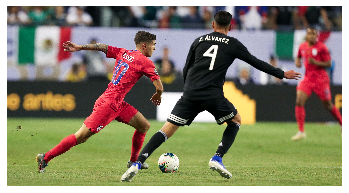

In [25]:
''' EXECUTION CODE '''
import matplotlib.pyplot as plt
import cv2
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

############################
# client display front-end
############################

SAMPLE_IMAGE = './sample_images/usmnt.jpg'
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
max_length = 34
model = load_model('captioner_model_from_cloud.h5')
photo = extract_features(SAMPLE_IMAGE)

description = generate_desc(model, tokenizer, photo, max_length)
description = cleanup_summary(description)

image = cv2.imread(SAMPLE_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)
print('AI-generated caption:\n*********************\n', description)